# Analysis of results from fast Sodium channel ABC calibration

This notebook compares the behaviour of the $I_\text{Na}$ current in Nygren, Courtemanche and standardised formulations.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyabc import History
from pyabc.weighted_statistics import weighted_mean, weighted_median

from ionchannelABC.visualization import plot_variables
from ionchannelABC.utils import weighted_cv

INFO:myokit:Loading Myokit version 1.28.3


## Load pyABC results databases for each run

Assumes that the results databases are stored in a subdirectory called `results'.

Loads history files and converts to dataframes and weights (see pyABC documentation).

#### Nygren

In [3]:
h_nyg_original = History('sqlite:///results/nygren/ina/original/nygren_ina_original.db')
h_nyg_unified = History('sqlite:///results/nygren/ina/unified/nygren_ina_unified.db')

In [7]:
df_nyg_original, w_nyg_original = h_nyg_original.get_distribution(m=0)
df_nyg_unified, w_nyg_unified = h_nyg_unified.get_distribution(m=0)

#### Courtemanche

In [5]:
# For Courtemanche original and unified are the same.
h_cou_m_original = History('sqlite:///results/courtemanche/ina/original/courtemanche_ina_mgate_original.db')
h_cou_h_original = History('sqlite:///results/courtemanche/ina/original/courtemanche_ina_hgate_original.db')
h_cou_j_original = History('sqlite:///results/courtemanche/ina/original/courtemanche_ina_jgate_original.db')

In [8]:
df_cou_m_original, w_cou_m_original = h_cou_m_original.get_distribution(m=0)
df_cou_h_original, w_cou_h_original = h_cou_h_original.get_distribution(m=0)
df_cou_j_original, w_cou_j_original = h_cou_j_original.get_distribution(m=0)

#### Standardised

In [9]:
h_sta = History('sqlite:///results/standardised/ina/standardised_ina_unified.db')

In [10]:
df_sta, w_sta = h_sta.get_distribution(m=0)

## Compare number of gating parameters in models

Generate bar plot using manually input numbers. See models and publications for source.

In [12]:
parameter_number = pd.DataFrame([['N',6,9],['C',6,25],['S',4,5]], 
                                columns = ['model', 'act', 'inact'])

In [13]:
# Hack to let different shading work in plotting
parameter_number.inact = parameter_number.act + parameter_number.inact

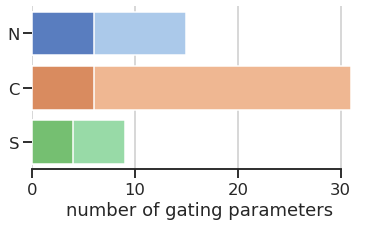

In [15]:
sns.set(style="ticks")
sns.set_context("talk")
sns.set_color_codes("pastel")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="inact", y="model", hue="model", data=parameter_number,
            palette="pastel", dodge=False)

sns.set_color_codes("muted")
sns.barplot(x="act", y="model", hue="model", data=parameter_number,
            palette="muted", dodge=False)

handles, labels = ax.get_legend_handles_labels()
order = []
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          ncol=2, loc="lower right", frameon=False)
ax.set(xlabel="number of gating parameters")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [142]:
#f.savefig('figures/ina/param_num_compare.pdf')

## Compare calibration between original and unified datasets

Plot relative standard deviation (RSD) of parameter posteriors and gating functions for Nygren and Courtemanche using the original dataset and unified datasets.

Note: we use the term RSD instead of CV (coefficient of variation) to avoid confusion with conduction velocity.

#### Calculate RSD values for Nygren and Courtemanche models

In [40]:
rsd_nyg_original = weighted_cv(df_nyg_original, 
                               w_nyg_original, 
                               sample_size=len(df_nyg_original))
model = ['N',]*len(rsd_nyg_original)
data = ['ORIGINAL',]*len(rsd_nyg_original)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_original}
nyg_original = pd.DataFrame(frame)

In [41]:
rsd_nyg_unified = weighted_cv(df_nyg_unified, 
                              w_nyg_unified, 
                              sample_size=len(df_nyg_unified))
model = ['N',]*len(rsd_nyg_unified)
data = ['UNIFIED',]*len(rsd_nyg_unified)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_unified}
nyg_unified = pd.DataFrame(frame)

In [42]:
rsd_cou_m = weighted_cv(df_cou_m_original, 
                        w_cou_m_original, 
                        sample_size=len(df_cou_m_original))
rsd_cou_h = weighted_cv(df_cou_h_original, 
                        w_cou_h_original, 
                        sample_size=len(df_cou_h_original))
rsd_cou_j = weighted_cv(df_cou_j_original, 
                        w_cou_j_original, 
                        sample_size=len(df_cou_j_original))

rsd_cou_original = pd.concat([rsd_cou_m, rsd_cou_h, rsd_cou_j])
model = ['C',]*len(rsd_cou_original)
data = ['ORIGINAL',]*len(rsd_cou_original)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_original}
cou_original = pd.DataFrame(frame)

In [46]:
# Courtemanche uses same original and unified datasets.
data = ['UNIFIED',]*len(rsd_cou_original)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_original}
cou_unified = pd.DataFrame(frame)

In [47]:
rsd_compare = pd.concat([nyg_original, nyg_unified, cou_original, cou_unified], sort=False)

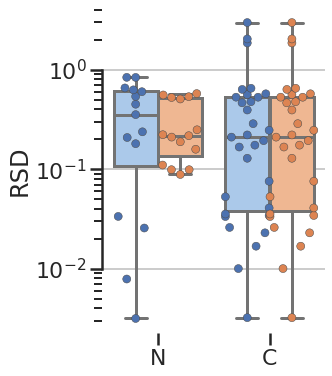

In [48]:
sns.set(style="ticks")
sns.set_context("poster")

# Initialize the figure
f, ax = plt.subplots(figsize=(4, 6))

# Plot the boxplot summary of RSD
sns.boxplot(x="model", y="RSD", hue="data", data=rsd_compare,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="model", y="RSD", hue="data", data=rsd_compare,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(ylabel="RSD")
ax.set_yscale('log')
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)
ax.get_legend().remove()

In [51]:
diff = nyg_unified.RSD-nyg_original.RSD
stats.wilcoxon(diff)

WilcoxonResult(statistic=40.0, pvalue=0.25598851167013814)

In [68]:
stats.mannwhitneyu(rsd_compare[(rsd_compare.model=='N') & (rsd_compare.data=='ORIGINAL')].RSD, 
                   rsd_compare[(rsd_compare.model=='C') & (rsd_compare.data=='ORIGINAL')].RSD)

MannwhitneyuResult(statistic=209.0, pvalue=0.294962999425457)

In [69]:
stats.mannwhitneyu(rsd_compare[(rsd_compare.model=='N') & (rsd_compare.data=='UNIFIED')].RSD, 
                   rsd_compare[(rsd_compare.model=='C') & (rsd_compare.data=='UNIFIED')].RSD)

MannwhitneyuResult(statistic=210.0, pvalue=0.30309800832203143)

In [49]:
#f.savefig('figures/ina/rsd_compare.pdf')

#### Compare underlying gating functions for each model

Sample from posterior particle population and plot resulting gating functions

In [52]:
# Number of samples
N = 100

In [55]:
nyg_par_samples_original = df_nyg_original.sample(n=N, weights=w_nyg_original, replace=True)
nyg_par_samples_original = nyg_par_samples_original.set_index([pd.Index(range(N))])
nyg_par_samples_original = nyg_par_samples_original.to_dict(orient='records')

In [56]:
nyg_par_samples_unified = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples_unified = nyg_par_samples_unified.set_index([pd.Index(range(N))])
nyg_par_samples_unified = nyg_par_samples_unified.to_dict(orient='records')

In [57]:
# Voltage range to plot gating functions over
v = np.arange(-140, 50, 0.5)

# Mapping an id to the parameter name in the mmt modelfile
nyg_par_map = {'mi': 'ina.m_ss',
               'mt': 'ina.tau_m',
               'hi': 'ina.h_ss',
               'ht': 'ina.tau_h1',
               'ji': 'ina.h_ss',
               'jt': 'ina.tau_h2'}

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


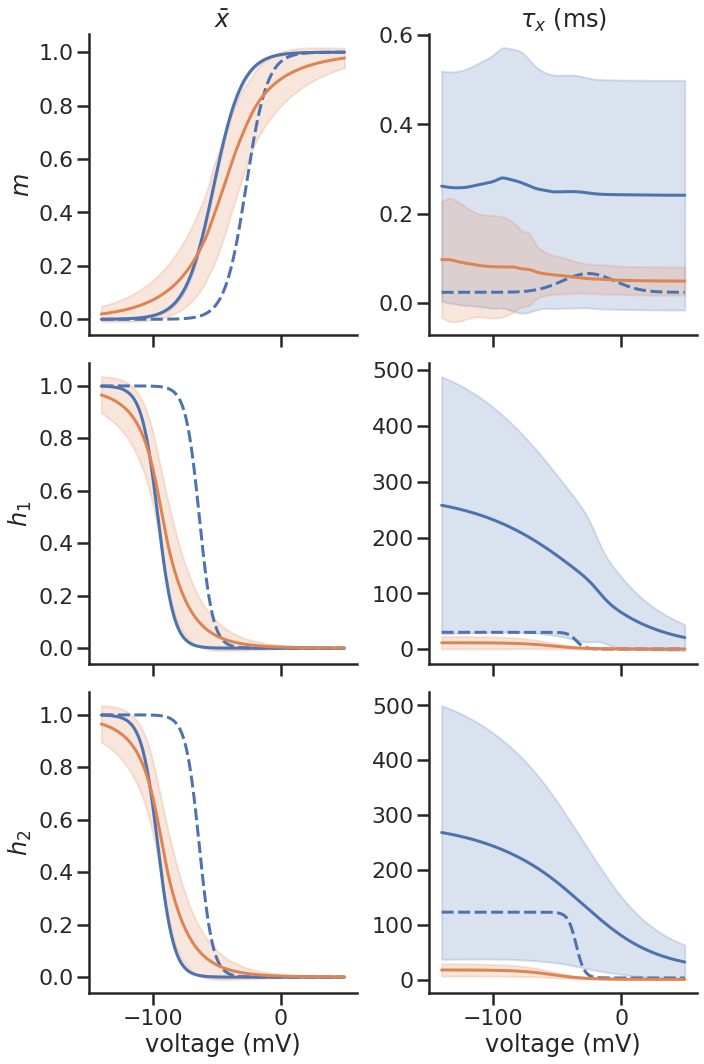

In [59]:
sns.set_context("poster")
sns.set_palette("deep")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plot_variables(v, 
                       [nyg_par_map, nyg_par_map], 
                       # The models only differ in the `name' metadata to separate their output when plotting.
                       ['models/nygren_ina.mmt', 'models/nygren_ina_.mmt'],
                       [nyg_par_samples_original, nyg_par_samples_unified],
                       original=[True,False],
                       figshape=(2,3))

ax[0][0].set_ylabel(r'$m$')
ax[1][0].set_ylabel(r'$h_1$')
ax[2][0].set_ylabel(r'$h_2$')
ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')
for a in ax[:,1].flatten():
    a.set_ylabel('')    
for a in ax[2][:]:
    a.set_xlabel('voltage (mV)')
    
plt.tight_layout()

In [60]:
#f.savefig('figures/ina/nyg_gating_functions.pdf')

In [61]:
cou_par_samples_m = df_cou_m_original.sample(n=N, weights=w_cou_m_original, replace=True)
cou_par_samples_m = cou_par_samples_m.set_index([pd.Index(range(N))])
cou_par_samples_h = df_cou_h_original.sample(n=N, weights=w_cou_h_original, replace=True)
cou_par_samples_h = cou_par_samples_h.set_index([pd.Index(range(N))])
cou_par_samples_j = df_cou_j_original.sample(n=N, weights=w_cou_j_original, replace=True)
cou_par_samples_j = cou_par_samples_j.set_index([pd.Index(range(N))])

cou_par_samples = (pd.concat([cou_par_samples_m, cou_par_samples_h, cou_par_samples_j], axis=1)
                   .to_dict(orient='records'))

In [62]:
cou_par_map = {'mi': 'ina.m_inf',
               'mt': 'ina.tau_m',
               'hi': 'ina.h_inf',
               'ht': 'ina.tau_h',
               'ji': 'ina.j_inf',
               'jt': 'ina.tau_j'}

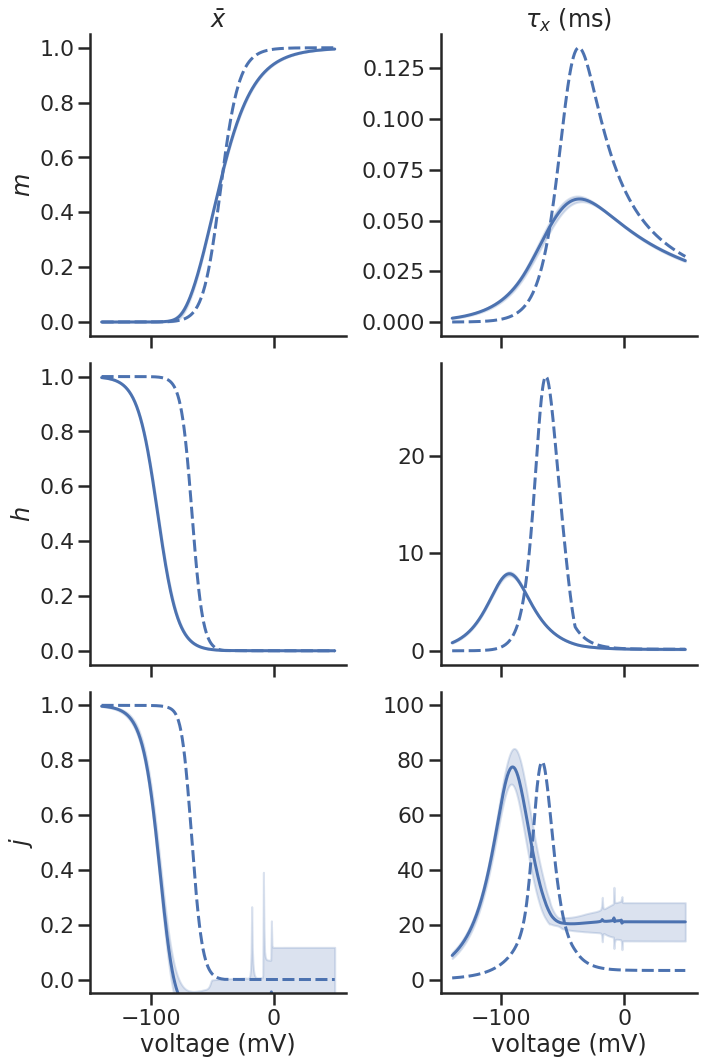

In [63]:
sns.set_context("poster")
sns.set_palette("deep")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plot_variables(v, cou_par_map, 
                       ["models/courtemanche_ina.mmt"], 
                       [cou_par_samples],
                       original=True,
                       figshape=(2,3))

ax[0][0].set_ylabel(r'$m$')
ax[1][0].set_ylabel(r'$h$')
ax[2][0].set_ylabel(r'$j$')
ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')
for a in ax[:,1].flatten():
    a.set_ylabel('')
for a in ax[:,0].flatten():
    a.set_ylim((-0.05, 1.05))    
ax[2,1].set_ylim((100*-0.05, 100*1.05))    
for a in ax[2][:]:
    a.set_xlabel('voltage (mV)')
    
plt.tight_layout()

In [64]:
#f.savefig('figures/ina/cou_gating_functions.pdf')

## Compare all models calibrated to unified dataset

### RSD of parameter posteriors

In [73]:
rsd_sta = weighted_cv(df_sta, w_sta, sample_size=len(df_sta))
model = ['S',]*len(rsd_sta)
frame = {'model': model, 'RSD': rsd_sta}
sta = pd.DataFrame(frame)

In [78]:
rsd_unified = pd.concat([nyg_unified, cou_unified, sta], sort=False)

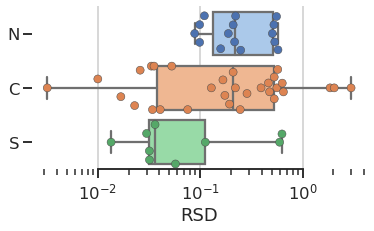

In [75]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x="RSD", y="model", data=rsd_unified,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="RSD", y="model", data=rsd_unified,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="RSD")
ax.set_xscale("log")
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [76]:
#f.savefig('figures/ina/rsd_compare_unified.pdf')

In [79]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=34.0, pvalue=0.024548990804632777)

In [80]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='C'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=98.0, pvalue=0.09209795590259495)

In [81]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='C'].RSD)

MannwhitneyuResult(statistic=210.0, pvalue=0.30309800832203143)

### Residuals to experimental data

In [88]:
# Sample number
N = 100

In [85]:
eps_nyg = h_nyg_unified.get_weighted_distances()

eps_nyg = eps_nyg.sample(n=N, axis=0, weights=eps_nyg.w, replace=True).distance
eps_nyg = pd.DataFrame({'model': 'N', 'eps': eps_nyg, 'exp': 'all'})

In [89]:
eps_cou_m = h_cou_m_original.get_weighted_distances()
eps_cou_h = h_cou_h_original.get_weighted_distances()
eps_cou_j = h_cou_j_original.get_weighted_distances()

eps_cou = np.array([])
eps_cou = (np.array(eps_cou_m.sample(n=N, axis=0, weights=eps_cou_m.w, replace=True).distance) +
           np.array(eps_cou_h.sample(n=N, axis=0, weights=eps_cou_h.w, replace=True).distance) +
           np.array(eps_cou_j.sample(n=N, axis=0, weights=eps_cou_j.w, replace=True).distance))

frame = {'model': 'C', 'eps': eps_cou, 'exp': 'all'}
eps_cou = pd.DataFrame(frame)

In [90]:
eps_sta = h_sta.get_weighted_distances()

eps_sta = eps_sta.sample(n=N, axis=0, weights=eps_sta.w, replace=True).distance
eps_sta = pd.DataFrame({'model': 'S', 'eps': eps_sta, 'exp': 'all'})

In [91]:
eps = pd.concat([eps_nyg, eps_cou, eps_sta])

In [92]:
eps['normalised'] = (eps['eps']-eps['eps'].min())/(eps['eps'].max()-eps['eps'].min())

Text(0, 0.5, 'normalised residual')

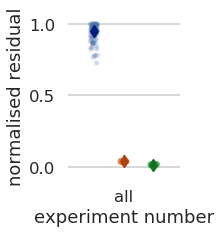

In [93]:
sns.set_context("talk")
sns.set_style("whitegrid")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plt.subplots(figsize=(2, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='normalised', hue='model', data=eps, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="normalised", hue="model",
              data=eps,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

ax.get_legend().remove()
ax.set_xlabel('experiment number')
ax.set_ylabel('normalised residual')

In [94]:
#f.savefig('figures/ina/eps_all_stripplot.pdf')

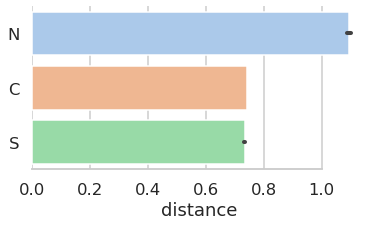

In [109]:
sns.set_context('talk')

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="eps", y="model", data=eps, palette='pastel')

ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="residual")
sns.despine(trim=True, left=True)

In [143]:
#f.savefig('figures/ina/eps_all_barplot.pdf')

Below we sample from the posterior particle populations and run the calibration experiments to be able to calculate a per-experiment epsilon value.

In [99]:
nyg_par_samples = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

cou_par_samples_m = df_cou_m_original.sample(n=N, weights=w_cou_m_original, replace=True)
cou_par_samples_m = cou_par_samples_m.set_index([pd.Index(range(N))])
cou_par_samples_m = cou_par_samples_m.to_dict(orient='records')

cou_par_samples_h = df_cou_h_original.sample(n=N, weights=w_cou_h_original, replace=True)
cou_par_samples_h = cou_par_samples_h.set_index([pd.Index(range(N))])
cou_par_samples_h = cou_par_samples_h.to_dict(orient='records')

cou_par_samples_j = df_cou_j_original.sample(n=N, weights=w_cou_j_original, replace=True)
cou_par_samples_j = cou_par_samples_j.set_index([pd.Index(range(N))])
cou_par_samples_j = cou_par_samples_j.to_dict(orient='records')

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

In [100]:
from ionchannelABC.experiment import setup
from ionchannelABC.distance import IonChannelDistance

In [101]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_inact_kin_slow,
                                        sakakibara_rec_fast,
                                        sakakibara_rec_slow)
from experiments.ina_schneider import (schneider_taum)
experiments = [sakakibara_act, 
               schneider_taum, 
               sakakibara_inact, 
               sakakibara_inact_kin_fast,
               sakakibara_inact_kin_slow,
               sakakibara_rec_fast,
               sakakibara_rec_slow]
models = ['models/nygren_ina_temp_adj.mmt',
          'models/courtemanche_ina.mmt',
          'models/standardised_ina.mmt']
par_samples = [nyg_par_samples, [cou_par_samples_m, cou_par_samples_h, cou_par_samples_j], std_par_samples]
names = ['N','C','S']

In [102]:
def experiment_dist(pars, modelfile, experiment):
    eps = []
    observ, model, sum_stats = setup(modelfile,
                                     experiment)
    obs = observ.to_dict()['y']
    obs = {str(k): v for k, v in obs.items()}
    dist = IonChannelDistance(exp_id=list(observ.exp_id),
                              variance=list(observ.variance),
                              delta=0.05)
    for sample in pars:
        eps.append(dist(sum_stats(model(sample)), obs, None))    
    return eps

The below cell calculates the per-experiment distance and may take some time to run depending on number of samples.

In [104]:
df = pd.DataFrame({})
mask = [None, [0, 0, 1, 1, 2, 1, 2], None] # Required to use correct samples for the Courtemanche model experiments

for j, exp in enumerate(experiments):
    df_ = pd.DataFrame({})
    for i, m in enumerate(models):
        if mask[i] is not None:
            eps = np.array(
                experiment_dist(par_samples[i][mask[i][j]],
                                m,
                                exp)
                )
        else:
            eps = np.array(
                experiment_dist(par_samples[i],
                                m,
                                exp)
                )
        df_ = df_.append(pd.DataFrame({'model': names[i],
                                       'exp': str(j),
                                       'eps': eps[~np.isinf(eps)]}))
    eps_max = df_['eps'].max()
    eps_min = df_['eps'].min()
    df_['eps'] = (df_['eps'] - eps_min)/(eps_max-eps_min)
    df = df.append(df_)

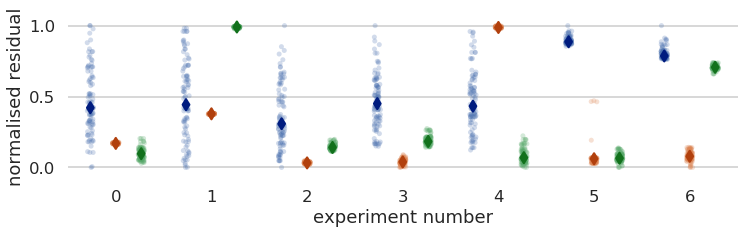

In [107]:
sns.set_context("talk")
sns.set_style("whitegrid")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

fig, ax = plt.subplots(figsize=(12, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='eps', hue='model', data=df, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="eps", hue="model",
              data=df,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="model",
          handletextpad=0, columnspacing=1,
          loc="best", ncol=3, frameon=True)
ax.set_xlabel('experiment number')
ax.set_ylabel('normalised residual')
ax.get_legend().remove()

In [144]:
#fig.savefig('figures/ina/eps_per_exp_stripplot.pdf')

### Summary statistics compared to experimental data

In [108]:
from ionchannelABC.visualization import plot_sim_results

In [109]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_inact_kin_slow,
                                        sakakibara_rec_fast,
                                        sakakibara_rec_slow)
from experiments.ina_schneider import (schneider_taum)

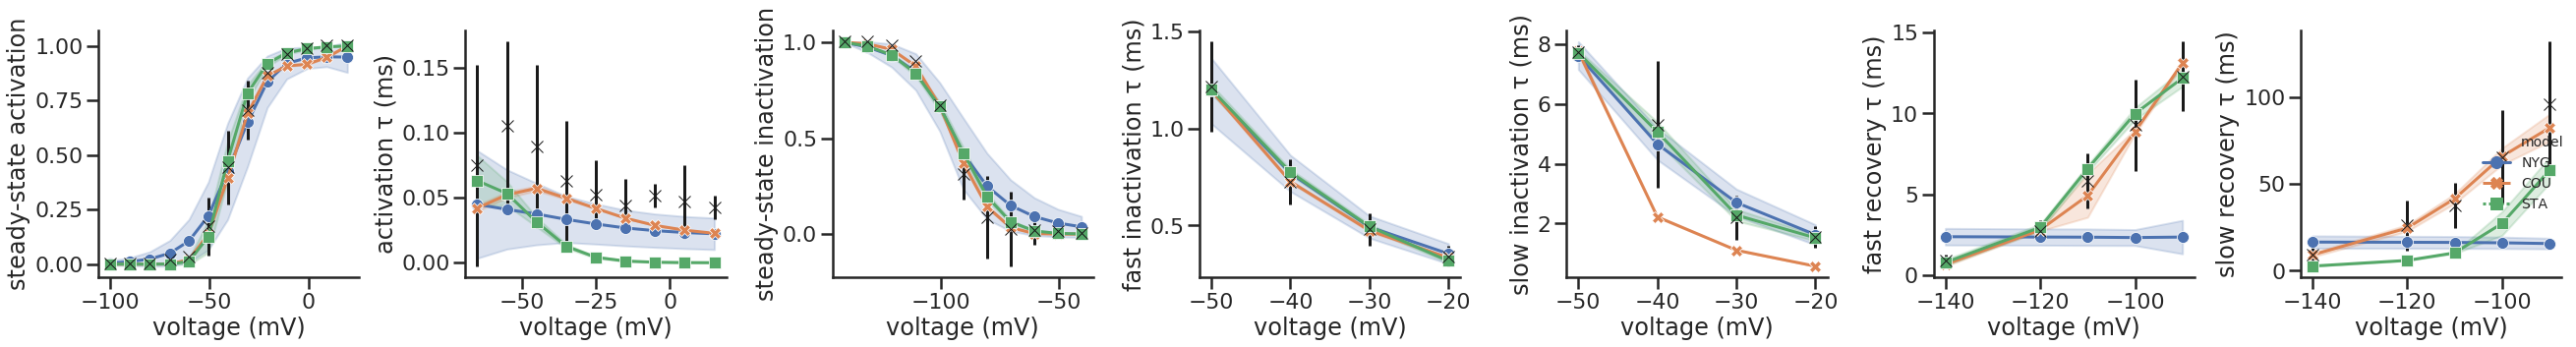

In [114]:
sns.set(style="ticks")
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(['models/nygren_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/standardised_ina.mmt'],
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_fast,
                     sakakibara_rec_slow,
                     temp_match_model=4, # scale all results to temperature of S model
                     masks=[None,
                            [0,1]+[None,]*5,
                            [None,]*2+[2,3,None,5,None],
                            [None,]*4+[4,None,6],
                            None],
                     df=[df_nyg_unified,
                         df_cou_m_original,
                         df_cou_h_original,
                         df_cou_j_original,
                         df_sta], 
                     w=[w_nyg_unified,
                        w_cou_m_original,
                        w_cou_h_original,
                        w_cou_j_original,
                        w_sta])


ylabels = ["steady-state activation", "activation τ (ms)", "steady-state inactivation",
           "fast inactivation τ (ms)", "slow inactivation τ (ms)", "fast recovery τ (ms)", 
           "slow recovery τ (ms)"]

for ax in g.axes.flatten():
    ax.set_xlabel("voltage (mV)")
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title("")

plt.tight_layout()

In [115]:
#g.savefig('figures/ina/compare_summary_statistics.pdf')

### Gating functions compared between models

In [116]:
nyg = 'models/nygren_ina_temp_adj.mmt' # Adjusted to same temperature using Q10=2.79
cou ='models/courtemanche_ina.mmt'
std = 'models/standardised_ina.mmt'

In [117]:
v = np.arange(-140, 50, 0.5)

In [118]:
std_par_map = {'mi': 'ina.m_ss',
               'hi': 'ina.h_ss',
               'ji': 'ina.h_ss',
               'mt': 'ina.tau_m',
               'ht': 'ina.tau_h1',
               'jt': 'ina.tau_h2'}

In [119]:
N = 100

nyg_par_samples = df_nyg_unified.sample(n=N, weights=w_nyg_unified, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

cou_par_samples_m = df_cou_m_original.sample(n=N, weights=w_cou_m_original, replace=True)
cou_par_samples_m = cou_par_samples_m.set_index([pd.Index(range(N))])
cou_par_samples_h = df_cou_h_original.sample(n=N, weights=w_cou_h_original, replace=True)
cou_par_samples_h = cou_par_samples_h.set_index([pd.Index(range(N))])
cou_par_samples_j = df_cou_j_original.sample(n=N, weights=w_cou_j_original, replace=True)
cou_par_samples_j = cou_par_samples_j.set_index([pd.Index(range(N))])
cou_par_samples = (pd.concat([cou_par_samples_m, cou_par_samples_h, cou_par_samples_j], axis=1)
                   .to_dict(orient='records'))

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

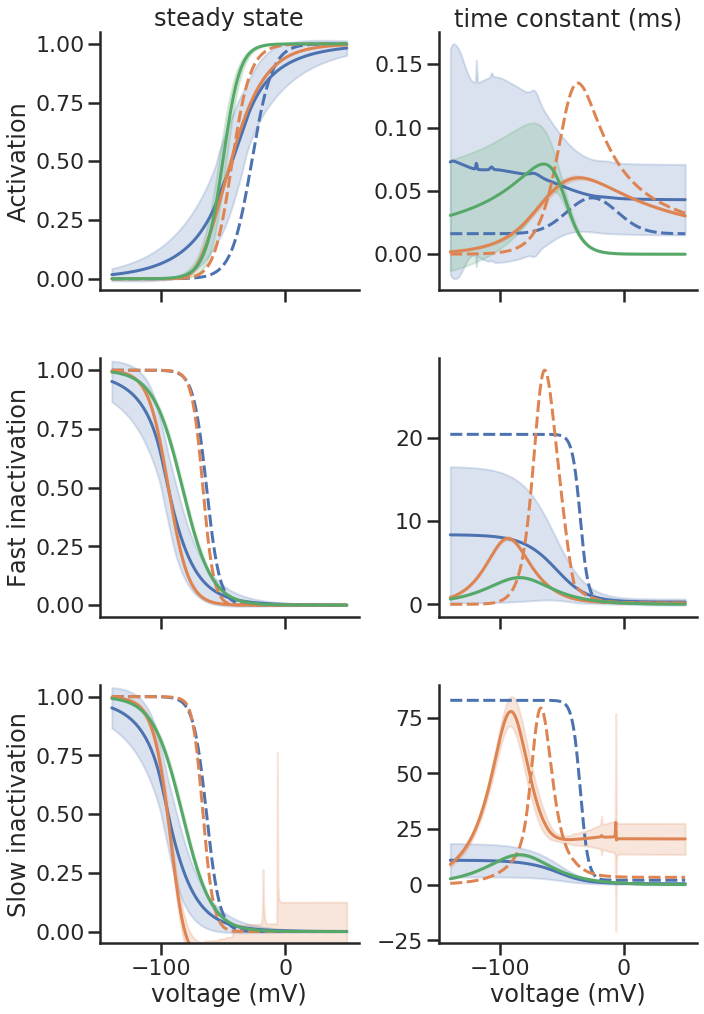

In [124]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_par_map, cou_par_map, std_par_map], 
                       [nyg, cou, std], 
                       [nyg_par_samples, cou_par_samples, std_par_samples],
                       original=[True, True, False],
                       figshape=(2,3))

ax[0][0].set_title('steady state')
ax[0][1].set_title('time constant (ms)')
ax[0][0].set_ylabel('Activation')
ax[1][0].set_ylabel('Fast inactivation')
ax[2][0].set_ylabel('Slow inactivation')

for a in ax[:,0]:
    a.set_ylim((-0.05, 1.05))

for a in ax[:,1]:
    a.set_ylabel('')
    
for a in ax[2,:]:
    a.set_xlabel('voltage (mV)')
    
for a in ax.flatten():
    x0,x1 = a.get_xlim()
    y0,y1 = a.get_ylim()
    a.set_aspect(abs(x1-x0)/abs(y1-y0))
    
plt.tight_layout()

In [125]:
#f.savefig('figures/ina/compare_gating_functions.pdf')

### Compare final pulse after pulse train

In [127]:
import myokit

nsteps = 100
period = 1000
tstep = 100
vhold = -140
vstep = -30

pulsetrain = myokit.pacing.steptrain([vstep,]*nsteps,
                                     vhold,
                                     period-tstep,
                                     tstep)

In [128]:
# nygren_ina_full has had tau values adjusted for temperature to 310K
models = [myokit.load_model(modelfile) for modelfile in ['models/nygren_ina_temp_adj.mmt',
                                                         'models/courtemanche_ina.mmt',
                                                         'models/standardised_ina.mmt']]
for m in models:
    pace = m.get('membrane.V')
    if pace.binding() != 'pace':
        if pace.is_state():
            pace.demote()
        pace.set_rhs(0)
        pace.set_binding('pace')

In [129]:
sims = [myokit.Simulation(m, pulsetrain) for m in models]

In [97]:
df_nyg_unified, w_nyg = h_nyg.get_distribution()
df_cou_m_original, w_cou_m = h_cou_m.get_distribution()
df_cou_h, w_cou_h = h_cou_h.get_distribution()
df_cou_j, w_cou_j = h_cou_j.get_distribution()
df_sta, w_sta = h_sta.get_distribution()

In [130]:
# Use parameter samples generated in previous section
par_samples = [nyg_par_samples, cou_par_samples, std_par_samples]

In [131]:
import time

all_samples = pd.DataFrame({})
for i, s in enumerate(sims):
    s.reset()
    # store original
    if models[i].name() != 'STA':
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ina.g','engine.time','membrane.V'],
                        log_interval=0.2)
        datalog = datalog.trim(9890, 9930, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ina.g']/max(datalog['ina.g']),
              'sample': 0,
              'model': models[i].name(),
              'type': 'original'}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)
    
    # re-calibrated
    for j, par_sample in enumerate(par_samples[i]):
        s.reset()
        for p, v in par_sample.items():
            name = p
            value = v
            if p.startswith("log"):
                name = p[4:]
                value = 10**v
            s.set_constant(name, value)
            
        # Log run time for comparisons
        t0 = time.time()
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ina.g','engine.time','membrane.V'],
                        log_interval=0.2)
        t1 = time.time()
        dt = t1-t0
        
        datalog = datalog.trim(9890, 9930, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ina.g']/max(datalog['ina.g']),
              'sample': j,
              'model': models[i].name(),
              'type': 'recalibrated',
              'runtime': dt}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)

In [132]:
recalibrated_df = all_samples[all_samples['type']=='recalibrated']

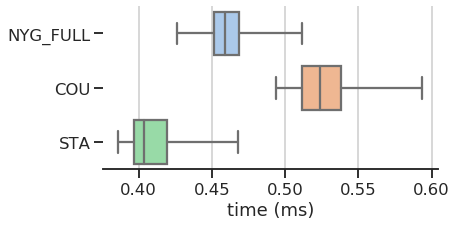

In [133]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x='runtime', y='model', data=recalibrated_df,
            palette="pastel", whis="range")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="time (ms)")
sns.despine(left=True)

In [134]:
#f.savefig('figures/ina/runtime_compare.pdf')

In [136]:
stats.mannwhitneyu(recalibrated_df[recalibrated_df.model=='STA'].runtime, 
                   recalibrated_df[recalibrated_df.model=='COU'].runtime,
                   alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [138]:
stats.mannwhitneyu(recalibrated_df[recalibrated_df.model=='COU'].runtime, 
                   recalibrated_df[recalibrated_df.model=='NYG'].runtime,
                   alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [137]:
stats.mannwhitneyu(recalibrated_df[recalibrated_df.model=='STA'].runtime, 
                   recalibrated_df[recalibrated_df.model=='NYG'].runtime,
                   alternative='two-sided')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [139]:
all_samples_detail = all_samples[(all_samples['time']>=9.8) & (all_samples['time'] < 12)]

Text(0.5, 1.0, '')

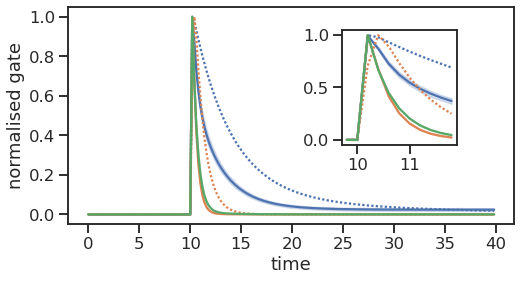

In [140]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(8,4))

g = sns.lineplot(x='time', y='gate', hue='model', style='type',
                 dashes = [(1,1),''],
                 data=all_samples, ax=ax,
                 legend=False)

ax2 = plt.axes([.6, .4, .2, .4])
sns.lineplot(x='time',y='gate',hue='model',style='type',
             dashes=[(1,1),''],
             data=all_samples_detail, ax=ax2,
             legend=False)
ax2.set_xlabel('')
ax2.set_ylabel('')

ax.set_ylabel('normalised gate')
ax.set_title('')

In [141]:
#f.savefig('figures/ina/trace_compare.pdf')